### Visualization examples

In [14]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from hmpai.data import SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, AR_STAGES
import numpy as np
from xhistogram.xarray import histogram
import tensorflow as tf
from hmpai.models import *
import visualkeras
from hmpai.training import (
    split_data_on_participants,
    train_and_evaluate,
    get_compile_kwargs,
)
from hmpai.normalization import *
import PIL

ModuleNotFoundError: No module named 'tensorflow'

#### Unprocessed distribution test

In [2]:
data_path_unprocessed = Path("../data/sat1/split_stage_data_unprocessed.nc")
data_unprocessed = xr.load_dataset(data_path_unprocessed)

In [26]:
# Checking distribution for each channels
for channel in data_unprocessed.channels:
    data_subset = data_unprocessed.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 100)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    # display(hist)
    hist.plot()

NameError: name 'data_unprocessed' is not defined

### Distribution test

In [2]:
data_path = Path("../data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([      3,       2,       2,       4,       8,       6,      12,
            26,      27,      39,      55,      98,     114,     171,
           260,     440,     758,    1332,    2340,    4103,    7639,
         14116,   26485,   48994,   91271,  168041,  306014,  534380,
        879064, 1304783, 1644998, 1675957, 1373503,  943238,  577483,
        332953,  186343,  104006,   58268,   32849,   19150,   11221,
          6652,    3887,    2321,    1444,     892,     501,     284,
           204,     118,      77,      30,      34,      18,      14,
             6,       0,       2], dtype=int64)
Coordinates:
  * data_bin  (data_bin) float64 -60.61 -58.63 -56.65 ... 50.32 52.3 54.28

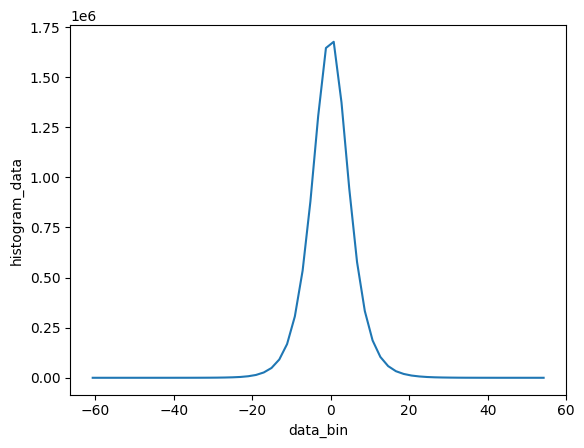

In [24]:
# Histogram of all values in dataset
# EEG data is already re-referenced to average value in preprocessing, so should be close to normal
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

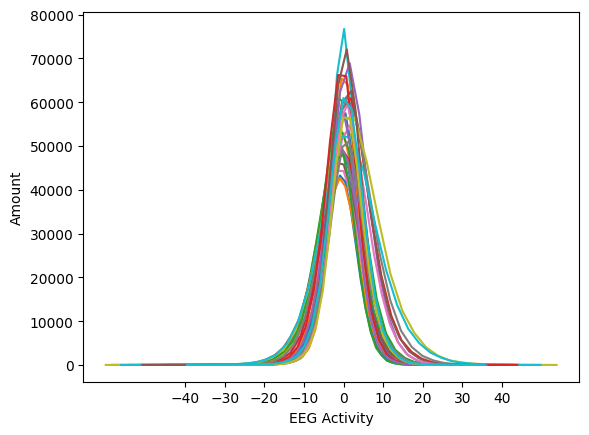

In [42]:
# Checking distribution for each channels, this means no within channel normalization is necessary
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    # display(hist)
    hist.plot()

plt.xlabel("EEG Activity")
plt.ylabel("Amount")
plt.xticks(np.arange(-40, 41, 10))
plt.show()

In [ ]:
sample_length = data.sel(channels="Fp1").data.isnull().idxmax("samples")
# Count occurences where length of samples for a label is higher than 100
np.count_nonzero(~np.isnan(sample_length.where(sample_length > 100).to_numpy()))

### Stage duration visualization

In [2]:
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data = xr.load_dataset(data_path)

In [3]:
acc_data = data.where(data.cue == "AC", drop=True)
sp_data = data.where(data.cue == "SP", drop=True)

In [4]:
max_idx_acc = (
    acc_data.sel(channels="Fp1", labels=SAT1_STAGES_ACCURACY)
    .data.isnull()
    .idxmax("samples")
)
avg_acc = max_idx_acc.where(max_idx_acc != 0).mean(dim="epochs", skipna=True)

max_idx_sp = (
    sp_data.sel(channels="Fp1", labels=SAT1_STAGES_ACCURACY)
    .data.isnull()
    .idxmax("samples")
)
avg_sp = max_idx_sp.where(max_idx_sp != 0).mean(dim="epochs", skipna=True)

In [6]:
# max_idx_acc = acc_data.sel(channels="Fp1").data.isnull().idxmax("samples")
# avg_acc = max_idx_acc.where(max_idx_acc != 0).mean(dim="epochs", skipna=True)

# max_idx_sp = sp_data.sel(channels="Fp1").data.isnull().idxmax("samples")
# avg_sp = max_idx_sp.where(max_idx_sp != 0).mean(dim="epochs", skipna=True)

/tmp/ipykernel_11851/469379149.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot1.set_xticklabels(avg_acc.labels.to_numpy(), rotation=45)
/tmp/ipykernel_11851/469379149.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot2.set_xticklabels(avg_sp.labels.to_numpy(), rotation=45)


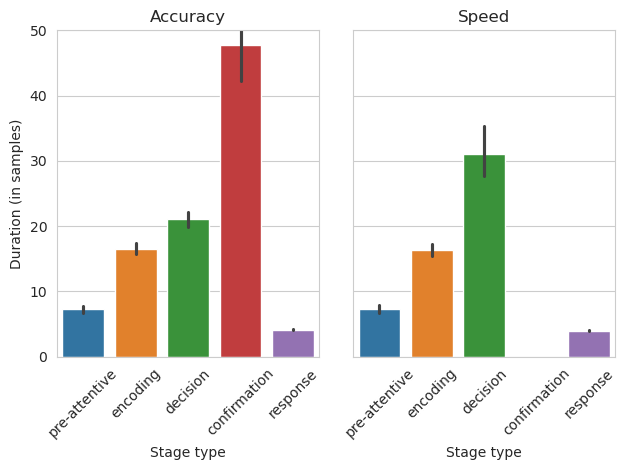

In [5]:
sns.set_style("whitegrid")

# sns.set_theme()
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

plt.setp(axes, ylim=(0, 50), xlabel="Stage type")

plot1 = sns.barplot(avg_acc, ax=axes[0])
plot2 = sns.barplot(avg_sp, ax=axes[1])

plot1.set_xticklabels(avg_acc.labels.to_numpy(), rotation=45)
plot1.set_ylabel("Duration (in samples)")
plot1.set_title("Accuracy")

plot2.set_xticklabels(avg_sp.labels.to_numpy(), rotation=45)
plot2.set_yticklabels([])
plot2.set_title("Speed")

plt.show()

#### AR

In [6]:
data_path = Path("../data/ar/split_stage_data.nc")
data = xr.load_dataset(data_path)

In [16]:
max_idx_ar = (
    data.sel(channels="FP1", labels=AR_STAGES)
    .data.isnull()
    .idxmax("samples")
)
avg_ar = max_idx_ar.where(max_idx_ar != 0).mean(dim="epochs", skipna=True)

/tmp/ipykernel_11851/4010179602.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot1.set_xticklabels(avg_ar.labels.to_numpy(), rotation=45)


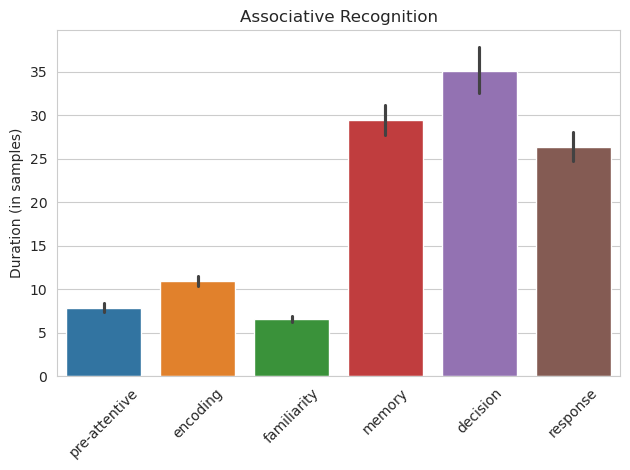

In [17]:
sns.set_style("whitegrid")

# sns.set_theme()
plt.rcParams["figure.autolayout"] = True
# f, axes = plt.subplots(1, 1)

plt.setp(axes, ylim=(0, 50), xlabel="Stage type")

plot1 = sns.barplot(avg_ar)


plot1.set_xticklabels(avg_ar.labels.to_numpy(), rotation=45)
plot1.set_ylabel("Duration (in samples)")
plot1.set_title("Associative Recognition")



plt.show()

In [3]:
model = SAT1Base(len(data.channels), len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())

In [14]:
model = SAT1GRU(len(data.channels), len(data.samples), len(data.labels))
model.compile(**get_compile_kwargs())

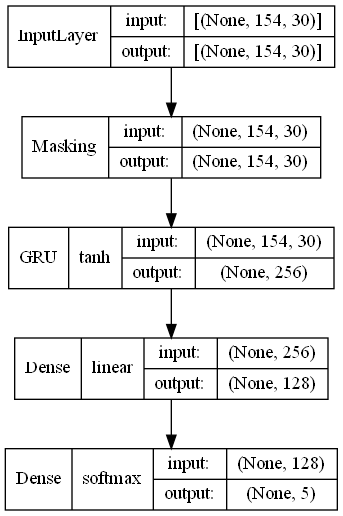

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

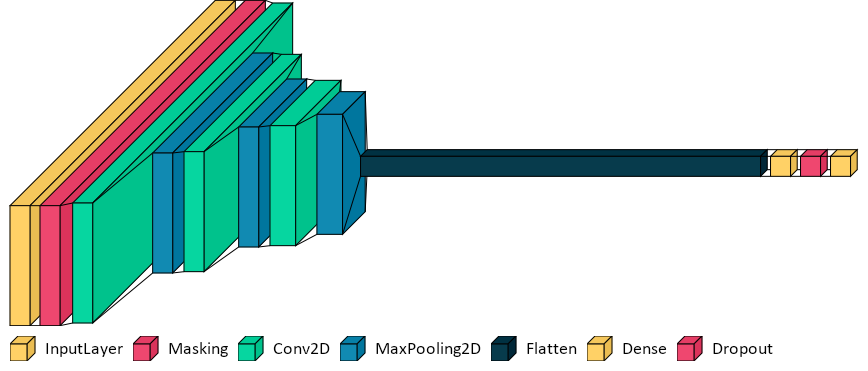

In [8]:
# Does not work for RNN models
visualkeras.layered_view(
    model, legend=True, font=PIL.ImageFont.truetype(font="calibri", size=18)
)

### Visualizing one epoch

In [4]:
data_path = Path("../data/sat1/stage_data.nc")
data = xr.load_dataset(data_path)

In [12]:
def plot_epoch(participant: str, epoch: int) -> None:
    single_epoch = data.sel(participant=participant, epochs=epoch).data

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(10, 2))

    # Display an image on the axes
    cax = ax.imshow(single_epoch, cmap="Spectral_r", vmin=-20, vmax=20)

    # Add a colorbar
    cbar = fig.colorbar(cax, orientation="vertical", ax=ax)

    # Optionally: Remove x and y tick labels if you want a clean plot
    ax.set_yticks([])
    # ax.set_yticks([])
    ax.set_xlabel("Time (in samples)")
    ax.set_ylabel("Channels")
    ax.set_xticks(np.arange(0, 225, 25))
    
    # Show the plot
    plt.show()

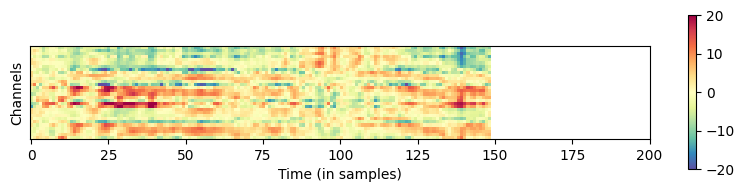

In [13]:
plot_epoch('0021', 46)

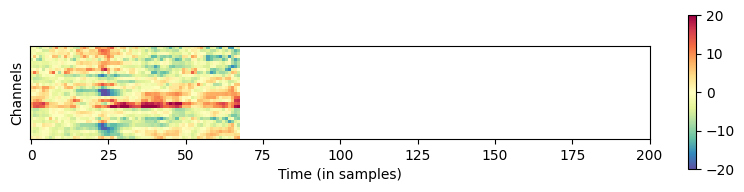

In [14]:
plot_epoch('0001', 1)

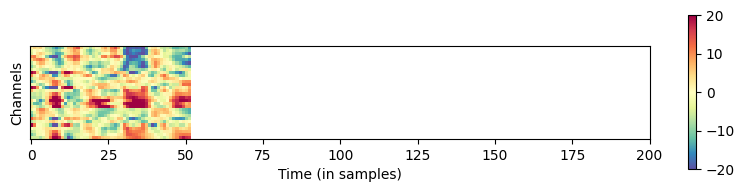

In [20]:
plot_epoch('0025', 160)

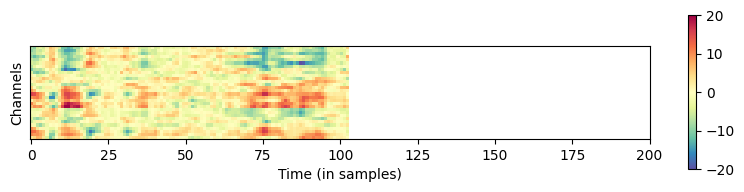

In [19]:
plot_epoch('0006', 22)